# Pymagicc Usage Examples

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 16, 9

In [2]:
# NBVAL_IGNORE_OUTPUT
from pprint import pprint

import pymagicc

In [3]:
from pymagicc import rcp26, rcp45, rcp60, rcp85, scenarios

## Scenarios

The four RCP scenarios are already preloaded in Pymagicc. They are loaded as objects with `df` and `metadata` attributes. `metadata` contains metadata

In [4]:
pprint(rcp26.metadata)

{'date': '26/11/2009 11:29:06; MAGICC-VERSION: 6.3.09, 25 November 2009',
 'header': '20\n'
           '41\n'
           'RCP3PD\n'
           'HARMONISED, EXTENDED FINAL RCP3-PD (Peak&Decline) NOV26; '
           'RCP3PD-Contact: IMAGE group, Detlef van Vuuren '
           '(Detlef.vanVuuren@pbl.nl)\n'
           'DATE: 26/11/2009 11:29:06; MAGICC-VERSION: 6.3.09, 25 November '
           '2009\n'
           'Final RCP3PD with constant emissions after 2100 using the default '
           'RCPtool MAGICC6.3 settings. Compiled by: '
           'malte.meinshausen@pik-potsdam.de'}


`df` contains a Pandas dataframe with all the scenario data.

In [5]:
rcp26.df.head()

,variable,todo,unit,region,time,value
0,Emissions|CO2|MAGICC Fossil and Industrial,SET,Gt C / yr,World|Bunkers,2000,0.0
1,Emissions|CO2|MAGICC Fossil and Industrial,SET,Gt C / yr,World|Bunkers,2001,0.0
2,Emissions|CO2|MAGICC Fossil and Industrial,SET,Gt C / yr,World|Bunkers,2002,0.0
3,Emissions|CO2|MAGICC Fossil and Industrial,SET,Gt C / yr,World|Bunkers,2003,0.0
4,Emissions|CO2|MAGICC Fossil and Industrial,SET,Gt C / yr,World|Bunkers,2004,0.0


They contain the following emissions with the following units

In [6]:
rcp26.df[["variable", "unit"]].drop_duplicates()

,variable,unit
0,Emissions|CO2|MAGICC Fossil and Industrial,Gt C / yr
20,Emissions|CO2|MAGICC AFOLU,Gt C / yr
40,Emissions|CH4,Mt CH4 / yr
60,Emissions|N2O,Mt N2ON / yr
80,Emissions|SOx,Mt S / yr
100,Emissions|CO,Mt CO / yr
120,Emissions|NMVOC,Mt NMVOC / yr
140,Emissions|NOx,Mt N / yr
160,Emissions|BC,Mt BC / yr
180,Emissions|OC,Mt OC / yr


The regions included are

In [7]:
pprint(rcp26.df.region.unique().tolist())

['World|Bunkers',
 'World|R5LAM',
 'World|R5MAF',
 'World|R5ASIA',
 'World|R5REF',
 'World|R5OECD',
 'World']


A plot of four categories in RCP3PD

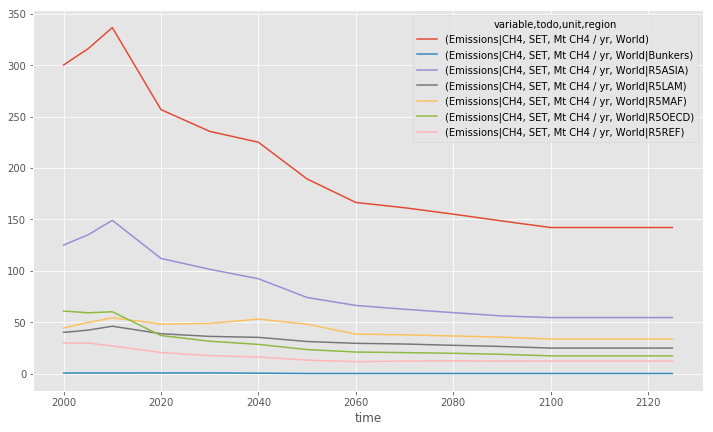

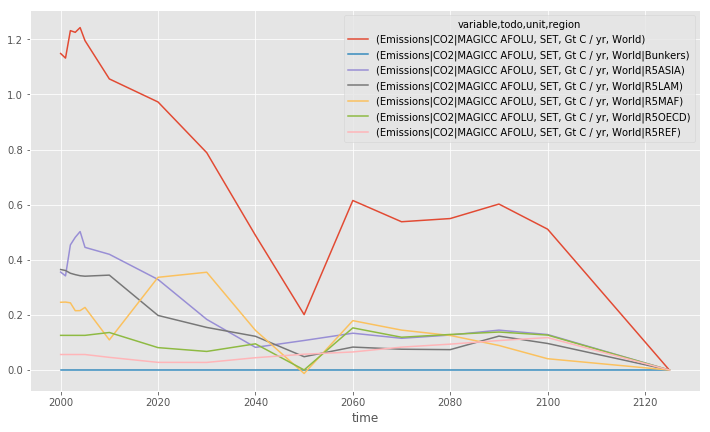

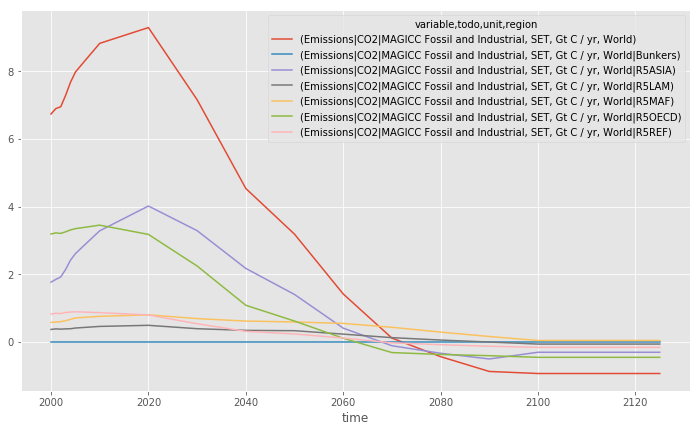

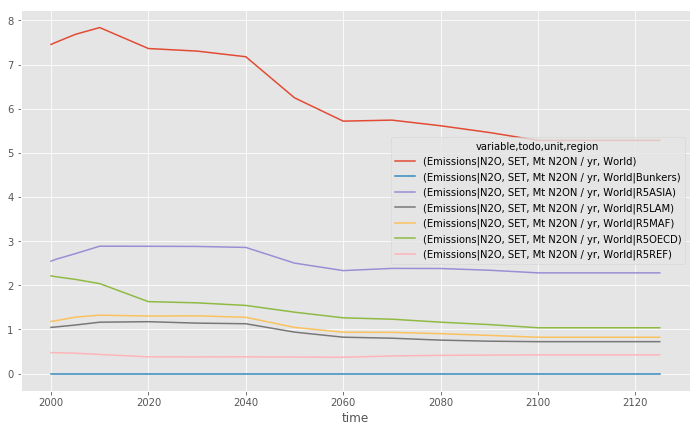

In [8]:
categories_to_plot = [
    "Emissions|" + v 
    for v in ["CO2|MAGICC Fossil and Industrial", "CO2|MAGICC AFOLU", "CH4", "N2O"]
]
subset_df = rcp26.df[
    (rcp26.df.variable.isin(categories_to_plot))
    & (rcp26.df.time < 2150) 
]

subset_df.pivot_table(
    values="value", index="time", columns=["variable", "todo", "unit", "region"]
).groupby(level="variable", axis=1).plot(figsize=(12, 7));

Fossil fuel emissions for the four RCP scenarios.

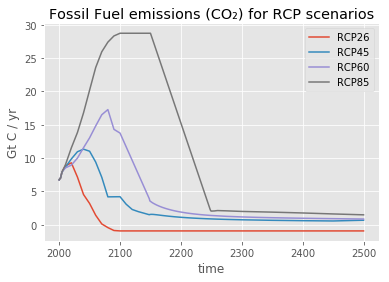

In [9]:
fig, ax = plt.subplots(1, 1)
for name, scen in scenarios.items():
    rows_to_plot = (
        (scen.df.region == "World")
        & (scen.df.variable == "Emissions|CO2|MAGICC Fossil and Industrial")
    )
    scen.df[rows_to_plot].plot(x="time", y="value", label=name, ax=ax)

plt.legend()
plt.ylabel(scen.df.unit[rows_to_plot].unique()[0])
plt.title("Fossil Fuel emissions (CO₂) for RCP scenarios");

## Running MAGICC

A single `pymagicc` run doesn't take long and returns the same object as used above.
(If not on Windows, the very first run might be slower due to setting up Wine.)

In [10]:
# NBVAL_IGNORE_OUTPUT
%time results = pymagicc.run(rcp26)

CPU times: user 1.59 s, sys: 129 ms, total: 1.72 s
Wall time: 7.19 s


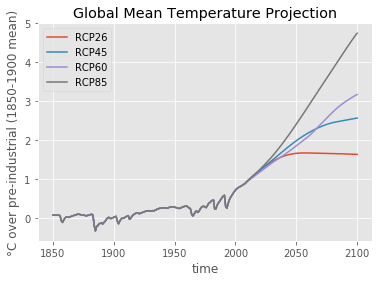

In [11]:
for name, scen in scenarios.items():
    results = pymagicc.run(scen)
    results_df = results.df
    results_df.set_index("time", inplace=True)    

    global_temp_time_rows = (
        (results_df.variable == "Surface Temperature")
        & (results_df.region == "World")
    )
    
    temp = (
        results_df.value[global_temp_time_rows].loc[1850:]
        - results_df.value[global_temp_time_rows].loc[1850:1900].mean()
    )
    temp.plot(label=name)
    
plt.legend()
plt.title("Global Mean Temperature Projection")
plt.ylabel("°C over pre-industrial (1850-1900 mean)");

The default parameters are the ones that were used to produce the RCP GHG concentrations (see also http://live.magicc.org/). Of course it's easy to change them.

In [12]:
low = pymagicc.run(rcp45, core_climatesensitivity=1.5)
default = pymagicc.run(rcp45, core_climatesensitivity=3)
high = pymagicc.run(rcp45, core_climatesensitivity=4.5)

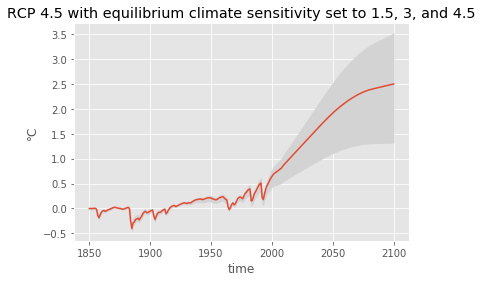

In [13]:
sel = slice(1850, 2100)
low_df = low.df.set_index("time")
high_df = high.df.set_index("time")
default_df = default.df.set_index("time")

plt.fill_between(
    low_df[(low_df.variable == "Surface Temperature") & (low_df.region == "World")].loc[sel].index,
    low_df[(low_df.variable == "Surface Temperature") & (low_df.region == "World")].loc[sel].value,
    high_df[(high_df.variable == "Surface Temperature") & (high_df.region == "World")].loc[sel].value,
    color="lightgray"
)
default_df[(default_df.variable == "Surface Temperature") & (default_df.region == "World")].loc[sel].value.plot()

plt.title(
    "RCP 4.5 with equilibrium climate sensitivity set to 1.5, 3, and 4.5"
)
plt.ylabel("°C");